# wordslab-images - Install prerequisites

In [18]:
from importlib.metadata import version

## Install Huggingface transformers and diffusers

In [ ]:
pip install accelerate

In [8]:
version('accelerate')

'1.0.0'

In [ ]:
pip install --upgrade transformers sentencepiece protobuf

In [10]:
version('transformers')

'4.45.2'

In [ ]:
pip install --upgrade diffusers

In [3]:
version('diffusers')

'0.30.3'

## Install Pytorch native quantization library torchao

Here is a repository explaining how to use torchao with the diffusers library:

https://github.com/sayakpaul/diffusers-torchao

https://github.com/sayakpaul/diffusers-torchao/blob/main/inference/serialization_and_loading.md

In [ ]:
pip install --upgrade torchao==0.5.0

In [9]:
version('torchao')

'0.5.0'

## Download and test 'FLUX.1 schnell' image generation model

FLUX.1 schnell is a state of the art image generation model released by Black Forest Labs under the very permissive Apache 2.0 licence.

https://blackforestlabs.ai/announcing-black-forest-labs/

It is optimized for speed of generation on consumer hardware.

Note that to run this model you will need :
- **32 GB of CPU RAM**
- **8 GB of GPU VRAM** (16 GB recommanded)
- 17 GB free disk space

Here is the relevant documentation for the Huggingface diffusers implementation:

https://huggingface.co/black-forest-labs/FLUX.1-schnell

https://huggingface.co/docs/diffusers/main/en/api/pipelines/flux

https://gist.github.com/sayakpaul/b664605caf0aa3bf8585ab109dd5ac9c

### Performance tests on RTX A6000 Ada 48GB with Pytorch 2.4 and torchao 0.5.0

#### Full pipeline

Memory after loading the model / Memory during generation at batch size 1 - Generation time

- bf16 : 32 630 / 37 360 MB - 2.5 sec
- int8 : 17 270 / 21 410 MB - 3.1 sec
- int4 :  9 950 / 13 780 MB - 11.5 sec

The pipeline executes the 4 models below, here is the memory necessary to load each model:

#### Text Encoder 1

- bf16 :   700 MB
- int8 : 1 020 MB
- int4 :   810 MB

#### Text Encoder 2

- bf16 : 9 520 MB
- int8 : 5 640 MB
- int4 : 3 620 MB

#### Diffusion Transformer

- bf16 : 23 130 MB
- int8 : 12 200 MB
- int4 :  7 400 MB

#### VAE

- bf16 : 600 MB
- int8 : 670 MB
- int4 : 670 MB

In [1]:
from pathlib import Path
from diffusers import DiffusionPipeline, FluxTransformer2DModel, AutoencoderKL
from transformers import T5EncoderModel, CLIPTextModel
from torchao.quantization import quantize_, int8_weight_only, int4_weight_only
import torch 

ckpt_id = "black-forest-labs/FLUX.1-schnell"
quant_precision = int8_weight_only()
model_dir = Path("FLUX.1-schnell-torchao-int8")

# FAILED to reload the transformer in 4 bits on RTX 3070: TensorCoreTiledAQTLayout not supported on CPU, because the model is too big to be put on the GPU in bf16 (what the code believes the weights are)
# quant_precision = int4_weight_only(use_hqq=True)
# model_dir = Path("FLUX.1-schnell-torchao-int4")

In [ ]:
############ Text Encoder 2 ############
text_encoder_2 = T5EncoderModel.from_pretrained(
    ckpt_id, subfolder="text_encoder_2", torch_dtype=torch.bfloat16
)
quantize_(text_encoder_2, quant_precision, device="cuda")
text_encoder_2.save_pretrained(model_dir/"text_encoder_2", safe_serialization=False)

In [ ]:
############ Diffusion Transformer ############
transformer = FluxTransformer2DModel.from_pretrained(
    ckpt_id, subfolder="transformer", torch_dtype=torch.bfloat16
)
quantize_(transformer, quant_precision, device="cuda")
transformer.save_pretrained(model_dir/"transformer", safe_serialization=False)

In [2]:
text_encoder = CLIPTextModel.from_pretrained(
    ckpt_id, subfolder="text_encoder", torch_dtype=torch.bfloat16
)

In [3]:
from torchao.dtypes import AffineQuantizedTensor
from torchao.dtypes.affine_quantized_tensor import PlainAQTLayout, PlainLayoutType, TensorCoreTiledAQTLayout, TensorCoreTiledLayoutType
from torchao.quantization.quant_primitives import ZeroPointDomain
torch.serialization.add_safe_globals([AffineQuantizedTensor,PlainAQTLayout,PlainLayoutType,ZeroPointDomain,TensorCoreTiledAQTLayout,TensorCoreTiledLayoutType])

In [4]:
text_encoder_2 = T5EncoderModel.from_pretrained(
       model_dir/"text_encoder_2", torch_dtype=torch.bfloat16, use_safetensors=False
)

In [5]:
transformer = FluxTransformer2DModel.from_pretrained(
    model_dir/"transformer", torch_dtype=torch.bfloat16, use_safetensors=False
)

/workspace/wordslab-images/.venv/lib/python3.12/site-packages/accelerate/utils/modeling.py:1517: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_f

In [16]:
text_encoder_2 = T5EncoderModel.from_pretrained(
       "wordslab-org/FLUX.1-schnell-torchao-int8", subfolder="text_encoder_2", torch_dtype=torch.bfloat16, use_safetensors=False
)

text_encoder_2/config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

In [17]:
transformer = FluxTransformer2DModel.from_pretrained(
     "wordslab-org/FLUX.1-schnell-torchao-int8", subfolder="transformer", torch_dtype=torch.bfloat16, use_safetensors=False
)

transformer/config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

(…)r/diffusion_pytorch_model.bin.index.json:   0%|          | 0.00/112k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

(…)ffusion_pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

(…)ffusion_pytorch_model-00002-of-00002.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

In [6]:
vae = AutoencoderKL.from_pretrained(
    ckpt_id, subfolder="vae", torch_dtype=torch.bfloat16
)

In [7]:
# Initialize the pipeline now.
pipeline = DiffusionPipeline.from_pretrained(
	ckpt_id, 
    transformer=transformer, 
    vae=vae,
    text_encoder=text_encoder, 
    text_encoder_2=text_encoder_2, 
    torch_dtype=torch.bfloat16
)
pipeline.enable_sequential_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [8]:
# Performance tests on RTX 3070Ti laptop
# int8 : 32 sec (after 3x warmup) - memory in use (compressed) : 24.0 GB 

In [13]:
%%time
image = pipeline(
    "studio photo of blonde woman, 45 years old, with short hair, blue eyes and black frame glasses and a dark green hoodie weared on top of a white tshirt", guidance_scale=0.0, num_inference_steps=4, max_sequence_length=256
).images[0]

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 4min 20s, sys: 331 ms, total: 4min 20s
Wall time: 4min 32s


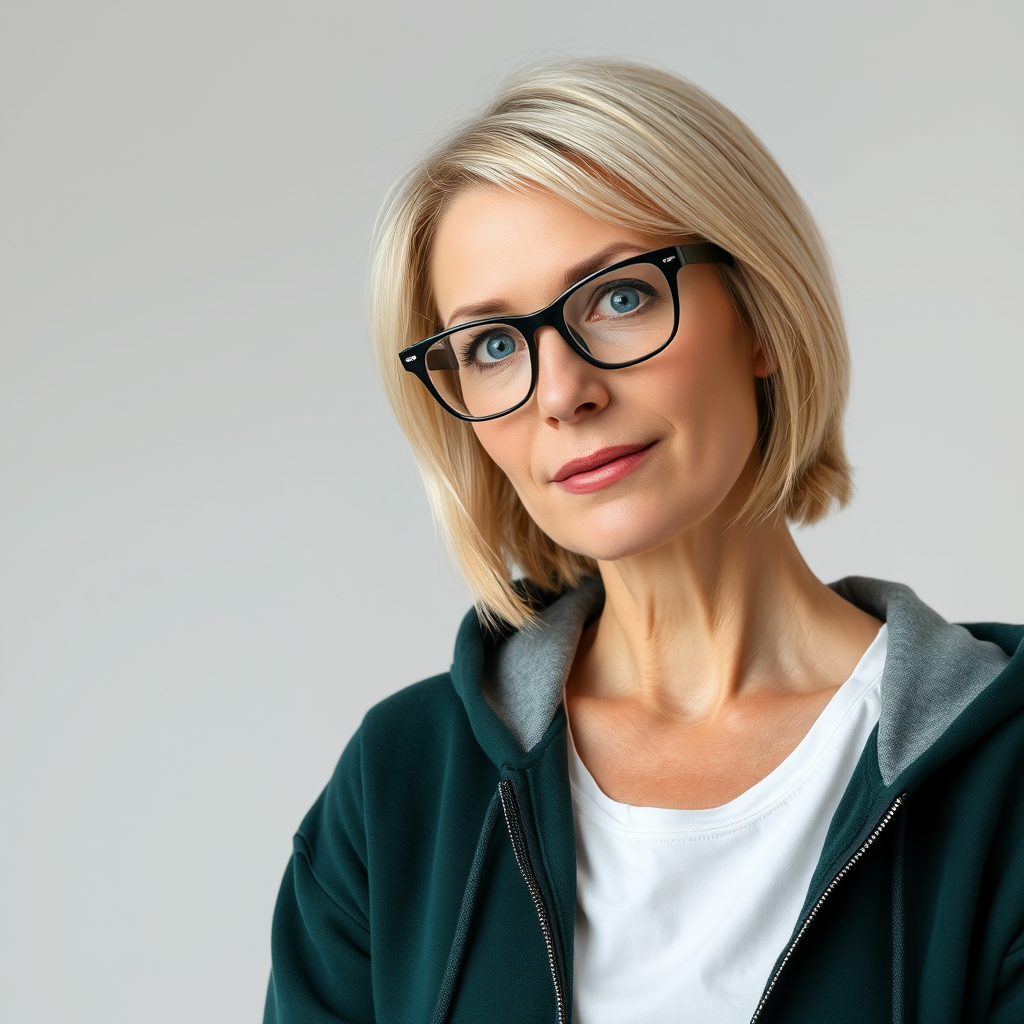

In [12]:
image

### Quantize FLUX text encoder 2 to INT4

- load 6 sec / quantize 28 sec / save 
- CPU max memory: 4 GB

In [1]:
import torch
from transformers import T5EncoderModel

text_encoder_2 = T5EncoderModel.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="text_encoder_2", torch_dtype=torch.bfloat16, revision="refs/pr/1")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from optimum.quanto import quantize, qint4, qint8, qfloat8, freeze

quantize(text_encoder_2, weights=qint4)
freeze(text_encoder_2)

In [ ]:
from pathlib import Path
from safetensors.torch import save_model
from optimum.quanto import quantization_map
import json

quantized_model_path = Path("/models/huggingface/quantized/black-forest-labs/FLUX.1-schnell-int4")
quantized_model_path.mkdir(parents=True, exist_ok=True)

# Some tensors share memory, this will lead to duplicate memory on disk and potential differences when loading them again: 
# [{'encoder.embed_tokens.weight', 'shared.weight'}].
# A potential way to correctly save your model is to use `save_model`.
# More information at https://huggingface.co/docs/safetensors/torch_shared_tensors
save_model(text_encoder_2, quantized_model_path / 'text_encoder_2.safetensors')
with open(quantized_model_path / 'text_encoder_2.quantization_map.json', 'w') as f:
  json.dump(quantization_map(text_encoder_2),f)

### Quantize FLUX transformer to INT4

- load 6 sec / quantize 28 sec / save 
- CPU max memory: 4 GB

In [ ]:
import torch
from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel

transformer = FluxTransformer2DModel.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="transformer", torch_dtype=torch.bfloat16, revision="refs/pr/1")

import json
from pathlib import Path
from optimum.quanto import freeze, qint4, qfloat8, quantize, quantization_map
from safetensors.torch import save_file

quantized_model_path = Path("/models/huggingface/quantized/black-forest-labs/FLUX.1-schnell-int4")
quantized_model_path.mkdir(parents=True, exist_ok=True)

quantize(transformer, weights=qint4)
freeze(transformer)

save_file(transformer.state_dict(), quantized_model_path / 'transformer.safetensors')
with open(quantized_model_path / 'transformer.quantization_map.json', 'w') as f:
  json.dump(quantization_map(transformer),f)

In [1]:
import time
import torch
from optimum.quanto import freeze, qfloat8, qint4, quantize
from diffusers import FlowMatchEulerDiscreteScheduler, AutoencoderKL
from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel
from diffusers.pipelines.flux.pipeline_flux import FluxPipeline
from transformers import CLIPTextModel, CLIPTokenizer,T5EncoderModel, T5TokenizerFast

# Load the model
scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="scheduler", revision="refs/pr/1")

In [2]:
# Model download: 1.71 GB
# VRAM before/after: 180 MB / 610MB 
# VRAM size: 430 MB (bf16)

text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.bfloat16)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.bfloat16)

In [3]:
text_encoder.to('cuda')
torch.torch.cuda.empty_cache()

In [4]:
text_encoder.to('cpu')
torch.torch.cuda.empty_cache()

In [12]:
# Model download: 9.52 GB
# VRAM before/after: 340 MB
# VRAM size:  GB

text_encoder_2 = T5EncoderModel.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="text_encoder_2", torch_dtype=torch.bfloat16, revision="refs/pr/1")
tokenizer_2 = T5TokenizerFast.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="tokenizer_2", torch_dtype=torch.bfloat16, revision="refs/pr/1")

# quantize to 8-bit to fit on an RTX 4090
# quantize(text_encoder_2, weights=qfloat8)
# quantize to 4-bit to fit on an RTX 3070
quantize(text_encoder_2, weights=qint4)
freeze(text_encoder_2)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [13]:
text_encoder_2.to('cuda')
torch.torch.cuda.empty_cache()

In [14]:
text_encoder_2.to('cpu')
torch.torch.cuda.empty_cache()

In [4]:
# Model download: 168 MB
# VRAM before: 3.7 GB
# VRAM after: 3.7 GB

vae = AutoencoderKL.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="vae", torch_dtype=torch.bfloat16, revision="refs/pr/1").to("cuda")

In [ ]:
# Model download: 23.78 GB
# VRAM before: 
# VRAM after: 

transformer = FluxTransformer2DModel.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="transformer", torch_dtype=torch.bfloat16, revision="refs/pr/1")
# quantize to 8-bit to fit on an RTX 4090
#quantize(transformer, weights=qfloat8)
# quantize to 4-bit to fit on an RTX 3070
quantize(transformer, weights=qint4)
freeze(transformer)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
pipe = FluxPipeline(
    scheduler=scheduler,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    text_encoder_2=None,
    tokenizer_2=tokenizer_2,
    vae=vae,
    transformer=None,
)
pipe.text_encoder_2 = text_encoder_2
pipe.transformer = transformer
#pipe.enable_model_cpu_offload()
pipe.enable_sequential_cpu_offload()

def generate_image(prompt):
    # Generate image from prompt
    image = pipe(
        prompt=prompt, 
        width=1024,
        height=1024,
        num_inference_steps=4, 
        generator=torch.Generator().manual_seed(int(time.time())),
        guidance_scale=3.5,
    ).images[0]
    
    return image

In [ ]:
generate_image("un lapin dort dans son un panier")